In [17]:
import os
import importlib
import melee 
import numpy as np
import pandas as pd
import data_processing 
importlib.reload(data_processing) 
from data_processing import process_slp_file, save_processed_data, process_and_save_sequences, process_archive_files_streaming, batch_process_archives, process_directory_slp_files
import torch

In [7]:
os.getcwd()

'/Users/alexoon/Desktop/smash_bot/icl_smash'

In [8]:
# # Process a single file
# slp_file = "./data/Stream-Game_20220828T223051.slp"
# sampled_data, columns = process_slp_file(slp_file)
# sampled_data.shape

# # Create and save sequences
# input_seqs, target_seqs = process_and_save_sequences(
#     sampled_data, 
#     "./training_data", 
#     "[libmeleeV2]example1",
#     input_len=10,
#     target_len=5
# )
# # Save the results
# # save_processed_data(sampled_data, columns, "./training_data", "[libmeleeV2]training_ex1.npy", save_csv=True)

# # Or use the main function directly
# # shape = main(slp_file, "./training_data", "DESIRED_FILENAME")

In [9]:
# Define input and output directories
data_dir = "./data"
output_dir = "./training_data"

# Make sure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process all .slp files
processed_count, failed = process_directory_slp_files(
    directory_path=data_dir,
    output_dir=output_dir,
    input_len=10,
    target_len=5
)

Found 3 .slp files to process


Processing .slp files:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

Column information written to: data/(...) Falco vs Falco (BABE) [DL] Game_20200122T213501_columns.txt
Saved sequences to ./training_data/(...) Falco vs Falco (BABE) [DL] Game_20200122T213501_sequences.npz


Processing .slp files:  67%|██████▋   | 2/3 [00:02<00:00,  1.03it/s]

Column information written to: data/(...) Falco vs Falcon (L$) [YS] Game_20200226T210843_columns.txt
Saved sequences to ./training_data/(...) Falco vs Falcon (L$) [YS] Game_20200226T210843_sequences.npz


Processing .slp files: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Column information written to: data/(...) Falco vs Falco (BABE) [BF] Game_20200122T213211_columns.txt
Saved sequences to ./training_data/(...) Falco vs Falco (BABE) [BF] Game_20200122T213211_sequences.npz

Successfully processed 3 files
Results saved to: ./training_data


# Testing Model Outputs

In [18]:
ACTIONS_VOCAB_AMOUNT = 404
CHARACTERS_VOCAB_AMOUNT = 35
STAGES_VOCAB_AMOUNT = 10

# Define enum dimensions (vocabulary sizes for each categorical feature)
enum_dims = {
    'stage': STAGES_VOCAB_AMOUNT,           # Number of possible stages
    'p1_action': ACTIONS_VOCAB_AMOUNT,      # Number of possible actions
    'p1_character': CHARACTERS_VOCAB_AMOUNT,    # Number of possible characters
    'p2_action': ACTIONS_VOCAB_AMOUNT,      # Number of possible actions
    'p2_character': CHARACTERS_VOCAB_AMOUNT     # Number of possible characters
}

# Define embedding dimensions for each enum feature
embedding_dims = {
    'stage': 16,          # Embedding dimension for stages
    'p1_action': 64,      # Embedding dimension for actions
    'p1_character': 16,   # Embedding dimension for characters
    'p2_action': 64,      # Embedding dimension for actions
    'p2_character': 16    # Embedding dimension for characters
}

In [ ]:
from models import MeleeEncoderDecoder
model = MeleeEncoderDecoder(
        continuous_dim=54,
        enum_dims=enum_dims,
        embedding_dims=embedding_dims,
        d_model=128,
        nhead=4,
        num_layers=3
    )
model.load_state_dict(torch.load("./models/May2nd_melee_predictor_all.pt", map_location=torch.device('cpu')))
model.eval() 

/Users/alexoon/Desktop/smash_bot/smash_venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


MeleeEncoderDecoder(
  (enum_embedder): EnumEmbeddingModule(
    (embeddings): ModuleDict(
      (stage): Embedding(10, 16)
      (p1_action): Embedding(404, 64)
      (p1_character): Embedding(35, 16)
      (p2_action): Embedding(404, 64)
      (p2_character): Embedding(35, 16)
    )
  )
  (encoder_proj): Linear(in_features=230, out_features=128, bias=True)
  (decoder_proj): Linear(in_features=230, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elem

In [ ]:
# Keep a running buffer (deque) of all the frames from the past 150 frames, keep track of every 15th frame
    # append current frame, then grab the slice of 15 spaced out
    # then grab the appropriate slice of 15 spaced out
    # then pass that in as a MeleeDataset object

# Then with the Melee dataset object, do something similar to training data s.t.
    # update Melee dataset object to have optional argument ("real-time" or something) telling it to use a passed in list of frames?
    # targets will not exist
    # only inputs
# x_continuous is the batch['continuous_inputs']



# Two options (It's kinda messy trying to predict the next 5 frames, so I'ma just grab the first frame from what it predicts):
    # 1) Predict every frame 
        # Less complicated, though a bit questionable since the model is trained at a different temporal frequency maybe (?)
    # 2) Predict every 15 frames and keep the same input for the next 15 frames?
        # Questionable if this actually works

# It would be great to actually just have the model output 1 thing next time AND also have a higher freq. sample rate

# Connecting to the Slippi Emulator

In [ ]:
def load_slp_file(file_path):
    """Initialize and connect to a SLP file."""
    console = melee.Console(
        is_dolphin=False,
        allow_old_version=True,
        path=file_path
    )
    console.connect()
    return console

In [4]:
import numpy as np
example = np.load("/Users/alexoon/Desktop/smash_bot/icl_smash/training_data/(...) Falco vs Falco (BABE) [BF] Game_20200122T213211_sequences.npz", allow_pickle=True)
example['inputs'].shape

(623, 10, 59)

(array([  3.,   1.,   3.,   1.,   0.,   0., 613.,   0.,   1.,   1.]),
 array([0.        , 0.0825    , 0.165     , 0.2475    , 0.33      ,
        0.41249999, 0.49499999, 0.57749999, 0.65999999, 0.74249999,
        0.82499999]),
 <BarContainer object of 10 artists>)

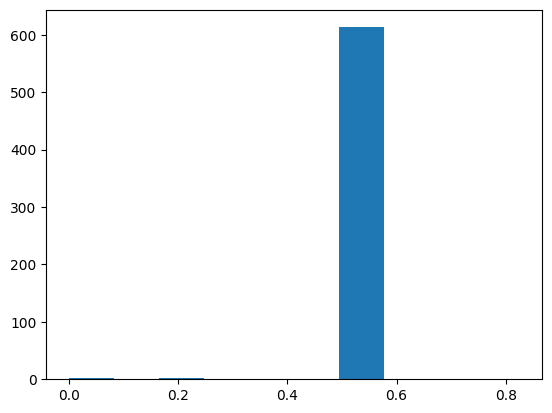

In [ ]:
inputs = example['inputs']
import matplotlib.pyplot as plt
plt.hist(x=inputs[:, 0, 4])

# consider clamping the values for button presses btw... (i.e. some outputs mean the button shouldn't be pressed by the model)